原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Using word embeddings
# 使用词嵌入

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 
 

将单词与向量相关联还有另一种常用的强大方法，就是使用密集的词向量（word vector），也叫词嵌入（word embedding）。one-hot 编码得到的向量是二进制的、稀疏的（绝大部分元素都是 0）、维度很高的（维度大小等于词表中的单词个数），而词嵌入是低维的浮点数向量（即密集向量，与稀疏向量相对），参见下图。与 one-hot 编码得到的词向量不同，词嵌入是从数据中学习得到的。常见的词向量维度是 256、512 或 1024（处理非常大的词表时）。与此相对，one-hot 编码的词向量维度通常为 20 000 或更高（对应包含 20 000 个标记的词表）。因此，词向量可以将更多的信息塞入更低的维度中。


![word embeddings vs. one hot encoding](data/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

获取词嵌入有两种方法。
* 在完成主任务（比如文档分类或情感预测）的同时学习词嵌入。在这种情况下，一开始是随机的词向量，然后对这些词向量进行学习，其学习方式与学习神经网络的权重相同。
 
* 在不同于待解决问题的机器学习任务上预计算好词嵌入，然后将其加载到模型中。这些词嵌入叫作预训练词嵌入（pretrained word embedding）。

我们来分别看一下这两种方法。


## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 


[...]


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

## 利用 Embedding 层学习词嵌入
要将一个词与一个密集向量相关联，最简单的方法就是随机选择向量。这种方法的问题在于，得到的嵌入空间没有任何结构。例如，accurate 和 exact 两个词的嵌入可能完全不同，尽管它们在大多数句子里都是可以互换的 a。深度神经网络很难对这种杂乱的、非结构化的嵌入空间进行学习。

说得更抽象一点，词向量之间的几何关系应该表示这些词之间的语义关系。词嵌入的作用应该是将人类的语言映射到几何空间中。例如，在一个合理的嵌入空间中，同义词应该被嵌入到相似的词向量中，一般来说，任意两个词向量之间的几何距离（比如 L2 距离）应该和这两个词的语义距离有关（表示不同事物的词被嵌入到相隔很远的点，而相关的词则更加靠近）。除了距离，你可能还希望嵌入空间中的特定方向也是有意义的。
在真实的词嵌入空间中，常见的有意义的几何变换的例子包括“性别”向量和“复数”向量。 例如，将 king（国王）向量加上 female（女性）向量，得到的是 queen（女王）向量。将 king（国王） 向量加上 plural（复数）向量，得到的是 kings 向量。词嵌入空间通常具有几千个这种可解释的、 并且可能很有用的向量。

[...]

有没有一个理想的词嵌入空间，可以完美地映射人类语言，并可用于所有自然语言处理任 务？可能有，但我们尚未发现。此外，也不存在人类语言（human language）这种东西。世界上有许多种不同的语言，而且它们不是同构的，因为语言是特定文化和特定环境的反射。但从更实际的角度来说，一个好的词嵌入空间在很大程度上取决于你的任务。英语电影评论情感分析 模型的完美词嵌入空间，可能不同于英语法律文档分类模型的完美词嵌入空间，因为某些语义关系的重要性因任务而异。

因此，合理的做法是对每个新任务都学习一个新的嵌入空间。幸运的是，反向传播让这种学习变得很简单，而 Keras 使其变得更简单。我们要做的就是学习一个层的权重，这个层就是 Embedding 层。


In [2]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
# Embedding 层至少需要两个参数： 
# 标记的个数（这里是 1000，即最大单词索引 +1）和嵌入的维度（这里是 64）
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

最好将 Embedding 层理解为一个字典，将整数索引（表示特定单词）映射为密集向量。它接收整数作为输入，并在内部字典中查找这些整数，然后返回相关联的向量。Embedding 层实际上是一种字典查找。


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

Embedding 层的输入是一个二维整数张量，其形状为 (samples, sequence_length)，每个元素是一个整数序列。它能够嵌入长度可变的序列，例如，对于前一个例子中的Embedding 层，你可以输入形状为 (32, 10)（32 个长度为 10 的序列组成的批量）或 (64,15)（64 个长度为 15 的序列组成的批量）的批量。不过一批数据中的所有序列必须具有相同的 长度（因为需要将它们打包成一个张量），所以较短的序列应该用 0 填充，较长的序列应该被截断。

这个Embedding 层返回一个形状为 (samples, sequence_length, embedding_dimensionality) 的三维浮点数张量。然后可以用 RNN 层或一维卷积层来处理这个三维张量（二者都会在后面介绍）。

将一个Embedding 层实例化时，它的权重（即标记向量的内部字典）最开始是随机的，与其他层一样。在训练过程中，利用反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用。一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。

我们将这个想法应用于你熟悉的 IMDB 电影评论情感预测任务。首先，我们需要快速准备数据。将电影评论限制为前 10 000 个最常见的单词（第一次处理这个数据集时就是这么做的）， 然后将评论长度限制为只有 20 个单词。对于这 10 000 个单词，网络将对每个词都学习一个 8 维嵌入，将输入的整数序列（二维整数张量）转换为嵌入序列（三维浮点数张量），然后将这个张量展平为二维，最后在上面训练一个Dense 层用于分类。


In [3]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
# 作为特征的单词个数
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
# 在这么多单词后截断文本（这些单词都属于前 max_features 个最常见的单词）
maxlen = 20

# Load the data as lists of integers.（将数据加载为整数列表）
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
# 将整数列表转换成形状为 (samples, maxlen) 的二维整数张量
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
# 指定 Embedding 层的最大输入长度，以便后面将嵌入输入展平。
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.
# Embedding 层 激活的形状为 (samples, maxlen, 8)
# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
# 将三维的嵌入张量展平成形状为 (samples, maxlen * 8) 的二维张量
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 237us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 3s 126us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 3s 126us/step - los

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

得到的验证精度约为 76%，考虑到仅查看每条评论的前 20 个单词，这个结果还是相当不错的。但请注意，仅仅将嵌入序列展开并在上面训练一个 Dense 层，会导致模型对输入序列中的每个单词单独处理，而没有考虑单词之间的关系和句子结构（举个例子，这个模型可能会将 this movie is a bomb 和 this movie is the bomb 两条都归为负面评论）。更好的做法是在嵌入序列上添加循环层或一维卷积层，将每个序列作为整体来学习特征。这也是接下来几节的重点。


## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## 使用预训练的词嵌入
有时可用的训练数据很少，以至于只用手头数据无法学习适合特定任务的词嵌入。那么应该怎么办？

你可以从预计算的嵌入空间中加载嵌入向量（你知道这个嵌入空间是高度结构化的，并且具有有用的属性，即抓住了语言结构的一般特点），而不是在解决问题的同时学习词嵌入。在自然语言处理中使用预训练的词嵌入，其背后的原理与在图像分类中使用预训练的卷积神经网络是一样的：没有足够的数据来自己学习真正强大的特征，但你需要的特征应该是非常通用的，比如常见的视觉特征或语义特征。在这种情况下，重复使用在其他问题上学到的特征，这种做法是有道理的。

这种词嵌入通常是利用词频统计计算得出的（观察哪些词共同出现在句子或文档中），用到的技术很多，有些涉及神经网络，有些则不涉及。Bengio 等人在 21 世纪初首先研究了一种思路，就是用无监督的方法计算一个密集的低维词嵌入空间，但直到最有名且最成功的词嵌入方案之一 word2vec 算法发布之后，这一思路才开始在研究领域和工业应用中取得成功。word2vec 算法由 Google 的 Tomas Mikolov 于 2013 年开发，其维度抓住了特定的语义属性，比如性别。

有许多预计算的词嵌入数据库，你都可以下载并在 Keras 的 Embedding 层中使用。word2vec 就是其中之一。另一个常用的是 GloVe（global vectors for word representation，词表示全局向量），由斯坦福大学的研究人员于 2014 年开发。这种嵌入方法基于对词共现统计矩阵进行因式分解。其开发者已经公开了数百万个英文标记的预计算嵌入，它们都是从维基百科数据和 Common Crawl 数据得到的。

我们来看一下如何在 Keras 模型中使用 GloVe 嵌入。同样的方法也适用于 word2vec 嵌入或其他词嵌入数据库。这个例子还可以改进前面刚刚介绍过的文本分词技术，即从原始文本开始，一步步进行处理。



## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

## 整合在一起：从原始文本到词嵌入

本节的模型与之前刚刚见过的那个类似：将句子嵌入到向量序列中，然后将其展平，最后在上面训练一个 Dense 层。但此处将使用预训练的词嵌入。此外，我们将从头开始，先下载IMDB 原始文本数据，而不是使用 Keras 内置的已经预先分词的 IMDB 数据。


### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

### 下载 IMDB 数据的原始文本
首先，打开 `http://ai.stanford.edu/~amaas/data/sentiment/` ，下载原始 IMDB 数据集并解压。 接下来，我们将训练评论转换成字符串列表，每个字符串对应一条评论。你也可以将评论
标签（正面 / 负面）转换成 labels 列表。

注：这一步我们已经做好了，不需要再下载，数据已经在 'data/aclImdb'目录。


In [6]:
import os

imdb_dir = 'data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...

### 对数据进行分词
利用本节前面介绍过的概念，我们对文本进行分词，并将其划分为训练集和验证集。

因为预训练的词嵌入对训练数据很少的问题特别有用（否则，针对于具体任务的嵌入可能效果更好），所以我们又添加了以下限制：将训练数据限定为前 200 个样本。因此，你需要在读取 200 个样本之后学习对电影评论进行分类。


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words（在 100 个单词后截断评论）
training_samples = 200  # We will be training on 200 samples（在 200 个样本上训练）
validation_samples = 10000  # We will be validating on 10000 samples（在 10 000 个样本上验证）
max_words = 10000  # We will only consider the top 10,000 words in the dataset（只考虑数据集中前 10 000 个最常见的单词）

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
# 将数据划分为训练集和验证集，但首先要打乱数据，因为一开始数据中的样本是排好序的（所有负面评论都在前面， 然后是所有正面评论）
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### 下载 GloVe 词嵌入
打开 https://nlp.stanford.edu/projects/glove ，下载 2014 年英文维基百科的预计算嵌入。这是 一个 822 MB 的压缩文件，文件名是 glove.6B.zip，里面包含 400 000 个单词（或非单词的标记） 的100 维嵌入向量。解压文件。

备注：我们下载了，文件放在 'data/glove.6B.100d.txt'


### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

### 对嵌入进行预处理
我们对解压后的文件（一个 .txt 文件）进行解析，构建一个将单词（字符串）映射为其向量表示（数值向量）的索引。


In [8]:
glove_dir = 'data/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

接下来，需要构建一个可以加载到 Embedding 层中的嵌入矩阵。它必须是一个形状为(max_words, embedding_dim) 的矩阵，对于单词索引（在分词时构建）中索引为 i 的单词， 这个矩阵的元素 i 就是这个单词对应的 embedding_dim 维向量。注意，索引 0 不应该代表任何单词或标记，它只是一个占位符。


In [9]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # 嵌入索引（embeddings_index） 中找不到的词，其嵌入向量全为 0
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

### 定义模型
我们将使用与前面相同的模型架构:


In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

### 在模型中加载 GloVe 嵌入
Embedding 层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素 i 是与索引 i 相关联的词向量。够简单。将准备好的 GloVe 矩阵加载到 Embedding 层中，即模型的第一层。


In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

此外，需要冻结 Embedding 层（即将其 trainable 属性设为 False），其原理和预训练的卷积神经网络特征相同，你已经很熟悉了。如果一个模型的一部分是经过预训练的（如 Embedding 层），而另一部分是随机初始化的（如分类器），那么在训练期间不应该更新预训练的部分，以避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。

### Train and evaluate

Let's compile our model and train it:

### 训练模型与评估模型
编译并训练模型：


In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.6337 - acc: 0.5250 - val_loss: 0.7130 - val_acc: 0.5100
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7565 - acc: 0.5800 - val_loss: 0.6910 - val_acc: 0.5418
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5956 - acc: 0.6950 - val_loss: 1.1205 - val_acc: 0.4936
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5335 - acc: 0.7350 - val_loss: 0.7134 - val_acc: 0.5362
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4713 - acc: 0.8100 - val_loss: 0.7177 - val_acc: 0.5589
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1448 - acc: 0.9800 - val_loss: 1.3373 - val_acc: 0.4952
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2545 - acc: 0.8800 - val_loss: 1.3110 - val_acc: 0.4960
Epoch 8/10
200/200 [========

Let's plot its performance over time:
	
    绘制结果：

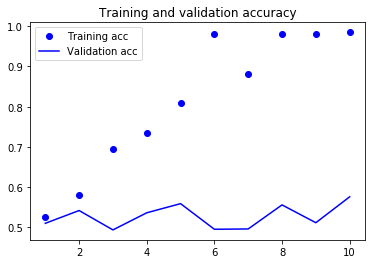

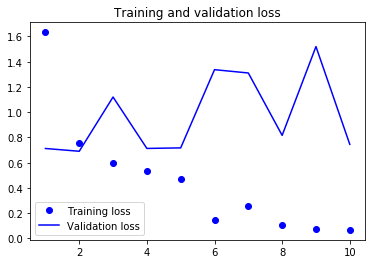

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 60s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

模型很快就开始过拟合，考虑到训练样本很少，这一点也不奇怪。出于同样的原因，验证精度的波动很大，但似乎达到了接近 60%。
 
注意，你的结果可能会有所不同。训练样本数太少，所以模型性能严重依赖于你选择的200个样本，而样本是随机选择的。如果你得到的结果很差，可以尝试重新选择 200 个不同的 随机样本，你可以将其作为练习（在现实生活中无法选择自己的训练数据）。

你也可以在不加载预训练词嵌入、也不冻结嵌入层的情况下训练相同的模型。在这种情况下， 你将会学到针对任务的输入标记的嵌入。如果有大量的可用数据，这种方法通常比预训练词嵌入更加强大，但本例只有 200 个训练样本。我们来试一下这种方法：。


In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6951 - acc: 0.4350 - val_loss: 0.6950 - val_acc: 0.5167
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5028 - a

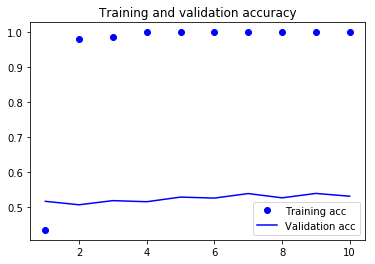

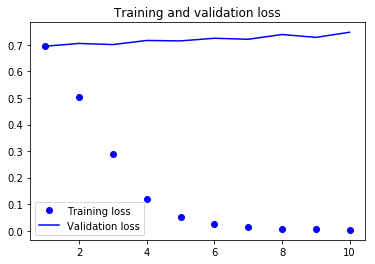

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

验证精度停留在 50% 多一点。因此，在本例中，预训练词嵌入的性能要优于与任务一起学习的嵌入。如果增加样本数量，情况将很快发生变化，你可以把它作为一个练习。

最后，我们在测试数据上评估模型。首先，你需要对测试数据进行分词。


In [18]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

接下来，加载并评估第一个模型。

In [19]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 59us/step


[0.744873430480957, 0.57604]

We get an appalling test accuracy of 57%. Working with just a handful of training samples is hard!

测试精度达到了令人震惊的 57% ！只用了很少的训练样本，得到这样的结果很不容易。